In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import StratifiedKFold

split_num = 10


# data input 
path = 'trainrat_new.txt'
data = pd.read_csv(path,sep=' ')
print(len(data))

# Data extraction,Win
win_data = data[data.label == "W"]
win_data = win_data.assign(W=1,D=0,L=0) 
win_data = win_data.drop("label",axis=1)
win_data = win_data.sample(n=len(win_data))# random sort

# Data extraction,Draw
draw_data = data[data.label == "D"]
draw_data = draw_data.assign(W=0,D=1,L=0)
draw_data = draw_data.drop("label",axis=1)
draw_data = draw_data.sample(n=len(draw_data))# random sort

# Data extraction,Lose
lose_data = data[data.label == "L"]
lose_data = lose_data.assign(W=0,D=0,L=1) 
lose_data = lose_data.drop("label",axis=1)
lose_data = lose_data.sample(n=len(lose_data))# random sort

# Group data together,use for normal k-fold
all_data = pd.concat([win_data, draw_data, lose_data])
all_data = all_data.sample(n=len(all_data))# random sort
#yAll = xAll[["W","D","L"]]

# Data drop
#xWin = xWin.drop(["W","D","L"],axis=1)
#xDraw = xDraw.drop(["W","D","L"],axis=1)
#xLose = xLose.drop(["W","D","L"],axis=1)
#xAll = xAll.drop(["W","D","L"],axis=1)

# Data separate and making dataset
win_data_separate = []
draw_data_separate = []
lose_data_separate = []
all_data_separate = []
wdl_separate = []
for i in range(split_num):
    win_data_separate.append(win_data[i::split_num])
    draw_data_separate.append(draw_data[i::split_num])
    lose_data_separate.append(lose_data[i::split_num])
    all_data_separate.append(all_data[i::split_num])
    # merge for stratified sampling
    wdl_separate.append(pd.concat([win_data_separate[i],draw_data_separate[i],lose_data_separate[i]]))
    # assign a number to make final input data
    wdl_separate[i] = wdl_separate[i].assign(separate_num=i)
    all_data_separate[i] = all_data_separate[i].assign(separate_num=i)

# integrate everything once
wdl_separate_merge = wdl_separate[0]
all_data_separate_merge = all_data_separate[0]
for i in range(1,split_num):
    wdl_separate_merge = wdl_separate_merge.append(wdl_separate[i])
    all_data_separate_merge = all_data_separate_merge.append(all_data_separate[i])

#print(len(wdl_separate_merge))
#print(len(all_data_separate_merge))
    
    
# make final input data
x_train = []
y_train = []
x_val = []
y_val = []
xAll_train = []
yAll_train = []
xAll_val = []
yAll_val = []
for i in range(split_num):
    x_train.append(wdl_separate_merge[wdl_separate_merge['separate_num'] != i])
    x_val.append(wdl_separate_merge[wdl_separate_merge['separate_num'] == i])
    xAll_train.append(all_data_separate_merge[all_data_separate_merge['separate_num'] != i])
    xAll_val.append(all_data_separate_merge[all_data_separate_merge['separate_num'] == i])
for i in range(split_num):
    # delete separate_num
    x_train[i] = x_train[i].drop(['separate_num'],axis=1)
    x_val[i] = x_val[i].drop(['separate_num'],axis=1)
    xAll_train[i] = xAll_train[i].drop(['separate_num'],axis=1)
    xAll_val[i] = xAll_val[i].drop(['separate_num'],axis=1)
    # random sort
    x_train[i] = x_train[i].sample(n=len(x_train[i]))
    x_val[i] = x_val[i].sample(n=len(x_val[i]))
    xAll_train[i] = xAll_train[i].sample(n=len(xAll_train[i]))
    xAll_val[i] = xAll_val[i].sample(n=len(xAll_val[i]))
    
    # separate x and y
    y_train.append(x_train[i][["W","D","L"]])
    y_val.append(x_val[i][["W","D","L"]])
    yAll_train.append(xAll_train[i][["W","D","L"]])
    yAll_val.append(xAll_val[i][["W","D","L"]])
    x_train[i] = x_train[i].drop(["W","D","L"],axis=1)
    x_val[i] = x_val[i].drop(["W","D","L"],axis=1)
    xAll_train[i] = xAll_train[i].drop(["W","D","L"],axis=1)
    xAll_val[i] = xAll_val[i].drop(["W","D","L"],axis=1)
    
    #translate pandas to numpy
    x_train[i] = x_train[i].values.astype('float32') 
    x_val[i] = x_val[i].values.astype('float32') 
    y_train[i] = y_train[i].values
    y_val[i] = y_val[i].values


28186


In [2]:
def RPS(y_true, y_pred):
    output = 0.
    data_num = len(y_true)
    for i in range(data_num):
        times = len(y_true[i]) - 1 
        cumulative_sum = 0.
        score = 0.
        for time in range(times):
            cumulative_sum += y_true[i,time] - y_pred[i,time]
            score += cumulative_sum ** 2
        score /= times
        output += score
    
    output /= data_num
    return output


In [3]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential

# craete model
# net としてインスタンス化
n_input = 8
n_hidden = 10
n_output = 3

# create 10 model for 10-fold-crossvalidation?
optimizer = []
net = []

for i in range(10):
    net.append(Sequential(
        L.Linear(n_input, n_hidden), F.relu,
        L.Linear(n_hidden, n_hidden), F.relu,
        L.Linear(n_hidden, n_output), F.softmax)
    )
    optimizer.append(chainer.optimizers.SGD(lr=0.01))
    optimizer[i].setup(net[i])
    



/home/tubotu/.local/lib/python3.6/site-packages/chainer/backends/cuda.py:143: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


In [4]:
#print(np.random.permutation(range(len(x_train))))
n_epoch = 100
batchsize = 16
# ログの保存用
results_train_data = []
results_valid_data = []


for data_num in range(len(x_train)):
    # ログの保存用
    results_train = {
        'loss': [],
        'accuracy': []
    }
    results_valid = {
        'loss': [],
        'accuracy': []
    }
    iteration = 0
    for epoch in range(n_epoch):
        # 各バッチ毎の目的関数の出力と分類精度の保存用
        loss_list = []
        #accuracy_list = []

        for i in range(0, len(x_train[data_num]), batchsize):
            # バッチを準備
            x_train_batch = x_train[data_num][i:i+batchsize,:]
            y_train_batch = y_train[data_num][i:i+batchsize,:]

            # 予測値を出力
            y_train_batch_pred = net[data_num](x_train_batch)
            # 目的関数を適用し、分類精度を計算
            loss_train_batch = RPS(y_train_batch, y_train_batch_pred)
            #print(loss_train_batch)
            #accuracy_train_batch = F.accuracy(y_train_batch_pred, y_train_batch)

            loss_list.append(loss_train_batch.array)
            #accuracy_list.append(accuracy_train_batch.array)

            # 勾配のリセットと勾配の計算
            net[data_num].cleargrads()
            loss_train_batch.backward()

            # パラメータの更新
            optimizer[data_num].update()

            # カウントアップ
            iteration += 1
        # 訓練データに対する目的関数の出力と分類精度を集計
        loss_train = np.mean(loss_list)
        #accuracy_train = np.mean(accuracy_list)

        # 1エポック終えたら、検証データで評価
        # 検証データで予測値を出力
        with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
            y_val_pred = net[data_num](x_val[data_num])

        #print(y_val)
        # 目的関数を適用し、分類精度を計算
        loss_val = RPS(y_val_pred, y_val[data_num])
        #accuracy_val = F.accuracy(y_val_pred, y_val[data_num])

        # 結果の表示
        print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
            epoch, iteration, loss_train, loss_val.array))

        # ログを保存
        results_train['loss'] .append(loss_train)
        #results_train['accuracy'] .append(accuracy_train)
        results_valid['loss'].append(loss_val.array)
        #results_valid['accuracy'].append(accuracy_val.array)
        
    results_train_data.append(results_train)
    results_valid_data.append(results_valid)


epoch: 0, iteration: 1586, loss (train): 0.2223, loss (valid): 0.2183
epoch: 1, iteration: 3172, loss (train): 0.2164, loss (valid): 0.2159
epoch: 2, iteration: 4758, loss (train): 0.2147, loss (valid): 0.2143
epoch: 3, iteration: 6344, loss (train): 0.2135, loss (valid): 0.2130
epoch: 4, iteration: 7930, loss (train): 0.2125, loss (valid): 0.2121
epoch: 5, iteration: 9516, loss (train): 0.2118, loss (valid): 0.2115
epoch: 6, iteration: 11102, loss (train): 0.2113, loss (valid): 0.2110
epoch: 7, iteration: 12688, loss (train): 0.2109, loss (valid): 0.2107
epoch: 8, iteration: 14274, loss (train): 0.2107, loss (valid): 0.2105
epoch: 9, iteration: 15860, loss (train): 0.2105, loss (valid): 0.2103
epoch: 10, iteration: 17446, loss (train): 0.2104, loss (valid): 0.2101
epoch: 11, iteration: 19032, loss (train): 0.2102, loss (valid): 0.2100
epoch: 12, iteration: 20618, loss (train): 0.2101, loss (valid): 0.2098
epoch: 13, iteration: 22204, loss (train): 0.2100, loss (valid): 0.2097
epoch: 1

epoch: 14, iteration: 23790, loss (train): 0.2095, loss (valid): 0.2094
epoch: 15, iteration: 25376, loss (train): 0.2095, loss (valid): 0.2093
epoch: 16, iteration: 26962, loss (train): 0.2094, loss (valid): 0.2093
epoch: 17, iteration: 28548, loss (train): 0.2094, loss (valid): 0.2092
epoch: 18, iteration: 30134, loss (train): 0.2093, loss (valid): 0.2092
epoch: 19, iteration: 31720, loss (train): 0.2093, loss (valid): 0.2092
epoch: 20, iteration: 33306, loss (train): 0.2093, loss (valid): 0.2091
epoch: 21, iteration: 34892, loss (train): 0.2092, loss (valid): 0.2091
epoch: 22, iteration: 36478, loss (train): 0.2092, loss (valid): 0.2091
epoch: 23, iteration: 38064, loss (train): 0.2092, loss (valid): 0.2090
epoch: 24, iteration: 39650, loss (train): 0.2092, loss (valid): 0.2090
epoch: 25, iteration: 41236, loss (train): 0.2091, loss (valid): 0.2090
epoch: 26, iteration: 42822, loss (train): 0.2091, loss (valid): 0.2089
epoch: 27, iteration: 44408, loss (train): 0.2091, loss (valid):

epoch: 28, iteration: 45994, loss (train): 0.2094, loss (valid): 0.2082
epoch: 29, iteration: 47580, loss (train): 0.2094, loss (valid): 0.2082
epoch: 30, iteration: 49166, loss (train): 0.2094, loss (valid): 0.2082
epoch: 31, iteration: 50752, loss (train): 0.2094, loss (valid): 0.2081
epoch: 32, iteration: 52338, loss (train): 0.2093, loss (valid): 0.2081
epoch: 33, iteration: 53924, loss (train): 0.2093, loss (valid): 0.2081
epoch: 34, iteration: 55510, loss (train): 0.2093, loss (valid): 0.2081
epoch: 35, iteration: 57096, loss (train): 0.2093, loss (valid): 0.2081
epoch: 36, iteration: 58682, loss (train): 0.2092, loss (valid): 0.2081
epoch: 37, iteration: 60268, loss (train): 0.2092, loss (valid): 0.2081
epoch: 38, iteration: 61854, loss (train): 0.2092, loss (valid): 0.2081
epoch: 39, iteration: 63440, loss (train): 0.2092, loss (valid): 0.2081
epoch: 40, iteration: 65026, loss (train): 0.2092, loss (valid): 0.2081
epoch: 41, iteration: 66612, loss (train): 0.2091, loss (valid):

epoch: 42, iteration: 68198, loss (train): 0.2089, loss (valid): 0.2087
epoch: 43, iteration: 69784, loss (train): 0.2089, loss (valid): 0.2087
epoch: 44, iteration: 71370, loss (train): 0.2089, loss (valid): 0.2087
epoch: 45, iteration: 72956, loss (train): 0.2089, loss (valid): 0.2087
epoch: 46, iteration: 74542, loss (train): 0.2089, loss (valid): 0.2087
epoch: 47, iteration: 76128, loss (train): 0.2089, loss (valid): 0.2087
epoch: 48, iteration: 77714, loss (train): 0.2088, loss (valid): 0.2087
epoch: 49, iteration: 79300, loss (train): 0.2088, loss (valid): 0.2086
epoch: 50, iteration: 80886, loss (train): 0.2088, loss (valid): 0.2086
epoch: 51, iteration: 82472, loss (train): 0.2088, loss (valid): 0.2086
epoch: 52, iteration: 84058, loss (train): 0.2088, loss (valid): 0.2086
epoch: 53, iteration: 85644, loss (train): 0.2088, loss (valid): 0.2086
epoch: 54, iteration: 87230, loss (train): 0.2088, loss (valid): 0.2086
epoch: 55, iteration: 88816, loss (train): 0.2088, loss (valid):

epoch: 56, iteration: 90402, loss (train): 0.2089, loss (valid): 0.2076
epoch: 57, iteration: 91988, loss (train): 0.2089, loss (valid): 0.2076
epoch: 58, iteration: 93574, loss (train): 0.2089, loss (valid): 0.2076
epoch: 59, iteration: 95160, loss (train): 0.2089, loss (valid): 0.2076
epoch: 60, iteration: 96746, loss (train): 0.2088, loss (valid): 0.2076
epoch: 61, iteration: 98332, loss (train): 0.2088, loss (valid): 0.2076
epoch: 62, iteration: 99918, loss (train): 0.2088, loss (valid): 0.2076
epoch: 63, iteration: 101504, loss (train): 0.2088, loss (valid): 0.2076
epoch: 64, iteration: 103090, loss (train): 0.2088, loss (valid): 0.2076
epoch: 65, iteration: 104676, loss (train): 0.2088, loss (valid): 0.2076
epoch: 66, iteration: 106262, loss (train): 0.2088, loss (valid): 0.2077
epoch: 67, iteration: 107848, loss (train): 0.2088, loss (valid): 0.2077
epoch: 68, iteration: 109434, loss (train): 0.2088, loss (valid): 0.2077
epoch: 69, iteration: 111020, loss (train): 0.2088, loss (

epoch: 70, iteration: 112606, loss (train): 0.2086, loss (valid): 0.2115
epoch: 71, iteration: 114192, loss (train): 0.2086, loss (valid): 0.2115
epoch: 72, iteration: 115778, loss (train): 0.2086, loss (valid): 0.2115
epoch: 73, iteration: 117364, loss (train): 0.2086, loss (valid): 0.2115
epoch: 74, iteration: 118950, loss (train): 0.2086, loss (valid): 0.2115
epoch: 75, iteration: 120536, loss (train): 0.2086, loss (valid): 0.2115
epoch: 76, iteration: 122122, loss (train): 0.2086, loss (valid): 0.2115
epoch: 77, iteration: 123708, loss (train): 0.2086, loss (valid): 0.2115
epoch: 78, iteration: 125294, loss (train): 0.2085, loss (valid): 0.2114
epoch: 79, iteration: 126880, loss (train): 0.2085, loss (valid): 0.2114
epoch: 80, iteration: 128466, loss (train): 0.2085, loss (valid): 0.2114
epoch: 81, iteration: 130052, loss (train): 0.2085, loss (valid): 0.2114
epoch: 82, iteration: 131638, loss (train): 0.2085, loss (valid): 0.2114
epoch: 83, iteration: 133224, loss (train): 0.2085,

epoch: 84, iteration: 134810, loss (train): 0.2084, loss (valid): 0.2091
epoch: 85, iteration: 136396, loss (train): 0.2084, loss (valid): 0.2091
epoch: 86, iteration: 137982, loss (train): 0.2084, loss (valid): 0.2091
epoch: 87, iteration: 139568, loss (train): 0.2084, loss (valid): 0.2091
epoch: 88, iteration: 141154, loss (train): 0.2084, loss (valid): 0.2091
epoch: 89, iteration: 142740, loss (train): 0.2084, loss (valid): 0.2091
epoch: 90, iteration: 144326, loss (train): 0.2084, loss (valid): 0.2091
epoch: 91, iteration: 145912, loss (train): 0.2084, loss (valid): 0.2091
epoch: 92, iteration: 147498, loss (train): 0.2084, loss (valid): 0.2091
epoch: 93, iteration: 149084, loss (train): 0.2084, loss (valid): 0.2091
epoch: 94, iteration: 150670, loss (train): 0.2084, loss (valid): 0.2091
epoch: 95, iteration: 152256, loss (train): 0.2084, loss (valid): 0.2091
epoch: 96, iteration: 153842, loss (train): 0.2084, loss (valid): 0.2090
epoch: 97, iteration: 155428, loss (train): 0.2084,

epoch: 98, iteration: 157014, loss (train): 0.2078, loss (valid): 0.2133
epoch: 99, iteration: 158600, loss (train): 0.2078, loss (valid): 0.2133
epoch: 0, iteration: 1586, loss (train): 0.2174, loss (valid): 0.2140
epoch: 1, iteration: 3172, loss (train): 0.2128, loss (valid): 0.2121
epoch: 2, iteration: 4758, loss (train): 0.2116, loss (valid): 0.2113
epoch: 3, iteration: 6344, loss (train): 0.2110, loss (valid): 0.2108
epoch: 4, iteration: 7930, loss (train): 0.2107, loss (valid): 0.2105
epoch: 5, iteration: 9516, loss (train): 0.2104, loss (valid): 0.2103
epoch: 6, iteration: 11102, loss (train): 0.2102, loss (valid): 0.2102
epoch: 7, iteration: 12688, loss (train): 0.2101, loss (valid): 0.2101
epoch: 8, iteration: 14274, loss (train): 0.2099, loss (valid): 0.2100
epoch: 9, iteration: 15860, loss (train): 0.2098, loss (valid): 0.2099
epoch: 10, iteration: 17446, loss (train): 0.2098, loss (valid): 0.2099
epoch: 11, iteration: 19032, loss (train): 0.2097, loss (valid): 0.2098
epoch:

epoch: 12, iteration: 20618, loss (train): 0.2104, loss (valid): 0.2091
epoch: 13, iteration: 22204, loss (train): 0.2103, loss (valid): 0.2090
epoch: 14, iteration: 23790, loss (train): 0.2102, loss (valid): 0.2089
epoch: 15, iteration: 25376, loss (train): 0.2101, loss (valid): 0.2088
epoch: 16, iteration: 26962, loss (train): 0.2100, loss (valid): 0.2087
epoch: 17, iteration: 28548, loss (train): 0.2099, loss (valid): 0.2086
epoch: 18, iteration: 30134, loss (train): 0.2099, loss (valid): 0.2086
epoch: 19, iteration: 31720, loss (train): 0.2098, loss (valid): 0.2085
epoch: 20, iteration: 33306, loss (train): 0.2098, loss (valid): 0.2085
epoch: 21, iteration: 34892, loss (train): 0.2097, loss (valid): 0.2084
epoch: 22, iteration: 36478, loss (train): 0.2097, loss (valid): 0.2084
epoch: 23, iteration: 38064, loss (train): 0.2097, loss (valid): 0.2084
epoch: 24, iteration: 39650, loss (train): 0.2096, loss (valid): 0.2083
epoch: 25, iteration: 41236, loss (train): 0.2096, loss (valid):

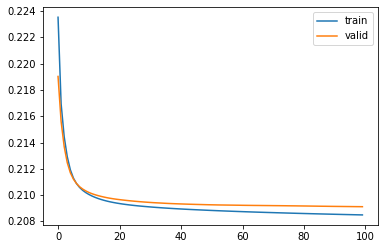

In [7]:

import matplotlib.pyplot as plt
results_train_data_all = []
results_valid_data_all = []
results_train_data_all = np.zeros(epoch+1)
results_valid_data_all = np.zeros(epoch+1)
# 目的関数の出力 (loss)
for i in range(split_num):   
    results_train_data_all += results_train_data[i]['loss']
    results_valid_data_all += results_valid_data[i]['loss']
    #plt.plot(results_train_data[i]['loss'], label='train')  # label で凡例の設定
    #plt.plot(results_valid_data[i]['loss'], label='valid')  # label で凡例の設定
    #plt.legend()  # 凡例の表示
    #plt.figure()

plt.plot(results_train_data_all / 10, label='train')  # label で凡例の設定
plt.plot(results_valid_data_all / 10, label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示


In [8]:
print(results_train_data_all)
print(results_valid_data_all)

[2.23535322 2.16941769 2.14440741 2.12920447 2.11931248 2.11298235
 2.1088088  2.1058611  2.10366723 2.1019666  2.10055968 2.09937321
 2.09835178 2.09745985 2.09669174 2.09601137 2.09540942 2.0948773
 2.09440427 2.09397469 2.09359266 2.09323308 2.0929094  2.09261194
 2.0923346  2.09207983 2.09183899 2.09161651 2.09140769 2.09120737
 2.09101495 2.09082516 2.09064701 2.09048007 2.09031411 2.09015957
 2.09001017 2.08986399 2.08972245 2.08958869 2.08945775 2.08932942
 2.0892092  2.08908944 2.08897673 2.08886774 2.08876173 2.08865374
 2.0885479  2.088443   2.08834404 2.08824261 2.08814463 2.08805083
 2.0879567  2.08786845 2.08778144 2.08769353 2.08760576 2.08752215
 2.0874356  2.087355   2.08727506 2.08719376 2.08711712 2.08704042
 2.08696543 2.08689326 2.08682288 2.08675259 2.08668332 2.08661352
 2.08654399 2.08647634 2.08640859 2.08633997 2.08627218 2.08620565
 2.08614154 2.0860807  2.08601677 2.08595604 2.08589441 2.08583617
 2.08577661 2.08571735 2.0856587  2.08560114 2.08554475 2.08548